In [5]:
import pandas as pd
import numpy as np

Pilot study with one sample

In [8]:
date_format = '%d.%m.%y %H:%M'

file_path = 'data/raw/subjectID_24.csv'
df24 = pd.read_csv(file_path)
# create a new data frame that contains the 10 minute average of each column
df24['Timestamp'] = pd.to_datetime(df24['Timestamp'], format=date_format)
df24 = df24.drop(columns=['ActivityClass', 'GalvanicSkinResponse'])
df24 = df24.set_index('Timestamp')
df24 = df24.resample('10T').mean()  # '10T' stands for 10 minutes
df24 = df24.reset_index()
df24


,Timestamp,ActivityCounts,Barometer,BloodPerfusion,BloodPulseWave,EnergyExpenditure,HR,HRV,RESP,Steps,SkinTemperature
0,2017-12-31 23:50:00,0.784314,976.400,1.565000,2.220000,292.000000,59.119471,34.123656,14.033886,0.0,34.7050
1,2018-01-01 00:00:00,1.137255,976.590,1.507000,2.268000,1094.500000,64.612757,39.131446,15.095639,0.0,35.5100
2,2018-01-01 00:10:00,2.156863,976.825,1.573500,3.115000,2214.200000,79.336830,44.155000,15.617629,0.0,35.1290
3,2018-01-01 00:20:00,0.784314,977.665,2.194000,2.087000,987.600000,59.600539,33.379380,16.030386,0.0,34.2690
4,2018-01-01 00:30:00,1.098039,977.865,2.156000,1.707000,960.000000,57.543399,34.909026,16.848911,0.0,33.9260
...,...,...,...,...,...,...,...,...,...,...,...
31058,2018-08-04 16:10:00,0.784314,982.970,0.738500,1.781000,1328.777501,47.667828,33.644959,14.445243,0.0,35.6050
31059,2018-08-04 16:20:00,0.784314,982.900,0.716000,1.738000,1330.995827,46.930095,35.539895,14.197552,0.0,35.3695
31060,2018-08-04 16:30:00,0.784314,982.805,0.551000,1.625000,1330.995827,48.638104,39.913934,13.815729,0.0,35.5805
31061,2018-08-04 16:40:00,0.823529,982.805,0.517500,1.649000,1330.995827,48.340401,42.712141,12.833625,0.0,35.8590


In [9]:
fatiguePROs = pd.read_csv('data/fatiguePROs_processed.csv')
subject24_labels = fatiguePROs[fatiguePROs['SubjectID'] == 24]
subject24_labels.reset_index(drop=True, inplace=True)
# convert the Timestamp column to datetime type
subject24_labels['DateTime'] = pd.to_datetime(subject24_labels['DateTime'], format=date_format)
# find all timestamp that have missing values in the proanswers column
missing_proanswers = subject24_labels[subject24_labels['PROanswer_value'].isnull()].DateTime.unique()
# drop all rows that have the above timestamps
subject24_labels = subject24_labels[~subject24_labels['DateTime'].isin(missing_proanswers)]
subject24_labels.reset_index(drop=True, inplace=True)
subject24_labels


/tmp/ipykernel_2772099/384756979.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject24_labels['DateTime'] = pd.to_datetime(subject24_labels['DateTime'], format=date_format)


,SubjectID,DateTime,Timezone,question,PROanswer_value
0,24,2017-12-13 21:00:00,CET,VAS,7.0
1,24,2017-12-13 21:00:00,CET,RelP,-1.0
2,24,2017-12-13 21:00:00,CET,PhF,2.0
3,24,2017-12-13 21:00:00,CET,MF,3.0
4,24,2017-12-14 21:00:00,CET,VAS,6.0
...,...,...,...,...,...
519,24,2018-08-03 20:00:00,CEST,MF,1.0
520,24,2018-08-04 20:01:00,CEST,VAS,3.0
521,24,2018-08-04 20:01:00,CEST,RelP,0.0
522,24,2018-08-04 20:01:00,CEST,PhF,0.0


In [10]:
unique_date_time = subject24_labels['DateTime'].unique()

# for each unique DateTime in subject24_labels, find the segment of df24 that are three days before the DateTime to the DateTime
# and append the segment to a new data frame
df24_5days = []
PROlabels_PhF = []
PROlabels_MF = []
PROlabels_VAS = []
PROlabels_RelP = []

for i in range(len(unique_date_time)):
    #  find the date of unique_date_time[i]

    start_date_time = max(unique_date_time[i] - pd.Timedelta(days=5), df24['Timestamp'].min())
    end_date_time = unique_date_time[i]
    
    segment = df24[(df24['Timestamp'] > start_date_time) & (df24['Timestamp'] <= end_date_time)]  
    # remove the timestamp column
    segment = segment.drop(columns=['Timestamp'])
    # if >=80% of the values in the segment are not NaN or None, append the segment to a new data frame
    if segment.size > 0 and segment.notnull().sum().sum() / segment.size >= 0.8:
        segment = segment.to_numpy()
        print(segment.size)
        df24_5days.append(segment)
        # find the PROlabel that corresponds to the DateTime, append it to PROlabels
        PROlabel = subject24_labels[subject24_labels['DateTime'] == end_date_time]
        PROlabels_PhF.append(PROlabel[PROlabel['question'] == 'PhF'].PROanswer_value.values[0])
        PROlabels_MF.append(PROlabel[PROlabel['question'] == 'MF'].PROanswer_value.values[0])
        PROlabels_VAS.append(PROlabel[PROlabel['question'] == 'VAS'].PROanswer_value.values[0])
        PROlabels_RelP.append(PROlabel[PROlabel['question'] == 'RelP'].PROanswer_value.values[0])
df24_5days


1270
2710
4150
5590
7030
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7200
7010


[array([[1.13725490e+00, 9.76590000e+02, 1.50700000e+00, ...,
         1.50956390e+01, 0.00000000e+00, 3.55100000e+01],
        [2.15686274e+00, 9.76825000e+02, 1.57350000e+00, ...,
         1.56176293e+01, 0.00000000e+00, 3.51290000e+01],
        [7.84313725e-01, 9.77665000e+02, 2.19400000e+00, ...,
         1.60303862e+01, 0.00000000e+00, 3.42690000e+01],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]),
 array([[1.13725490e+00, 9.76590000e+02, 1.50700000e+00, ...,
         1.50956390e+01, 0.00000000e+00, 3.55100000e+01],
        [2.15686274e+00, 9.76825000e+02, 1.57350000e+00, ...,
         1.56176293e+01, 0.00000000e+00, 3.51290000e+01],
        [7.84313725e-01, 

In [11]:
df24_5days[1]

array([[1.13725490e+00, 9.76590000e+02, 1.50700000e+00, ...,
        1.50956390e+01, 0.00000000e+00, 3.55100000e+01],
       [2.15686274e+00, 9.76825000e+02, 1.57350000e+00, ...,
        1.56176293e+01, 0.00000000e+00, 3.51290000e+01],
       [7.84313725e-01, 9.77665000e+02, 2.19400000e+00, ...,
        1.60303862e+01, 0.00000000e+00, 3.42690000e+01],
       ...,
       [2.00000000e+00, 9.82300000e+02, 7.71000000e-01, ...,
        1.61698578e+01, 8.10000000e+00, 3.40810000e+01],
       [9.01960784e-01, 9.82045000e+02, 9.78500000e-01, ...,
        1.49654989e+01, 0.00000000e+00, 3.36605000e+01],
       [1.21568627e+00, 9.81875000e+02, 1.08600000e+00, ...,
        1.56460594e+01, 0.00000000e+00, 3.36220000e+01]])

In [12]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
np.random.seed(0)
# Assuming your data is stored in 'data' and labels in 'labels'
X_train, X_test, y_train, y_test = train_test_split(df24_5days, PROlabels_VAS, test_size=0.2, random_state=42)

from torch.nn.utils.rnn import pad_sequence
# Pad sequences with zeros
X_train = pad_sequence([torch.tensor(seq, dtype=torch.float32) for seq in X_train], batch_first=True, padding_value=float('nan'))
X_test = pad_sequence([torch.tensor(seq, dtype=torch.float32) for seq in X_test], batch_first=True, padding_value=float('nan'))
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_train = torch.nan_to_num(X_train)
X_test = torch.nan_to_num(X_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape


(torch.Size([56, 720, 10]),
 torch.Size([56]),
 torch.Size([14, 720, 10]),
 torch.Size([14]))

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Define the LSTM model with consistency self-attention
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, consistency_attention_size):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.consistency_attention = nn.Linear(hidden_size, consistency_attention_size)
        # self.fc = nn.Linear(hidden_size, output_size)
        self.fc = nn.Linear(hidden_size + consistency_attention_size, output_size)

        self.relu = nn.ReLU()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        
        # Calculate consistency attention
        attention_weights = torch.softmax(self.relu(self.consistency_attention(out)), dim=-1)
        context = torch.sum(attention_weights * out, dim=1)
        
        # Concatenate LSTM output and attention context
        out = torch.cat((out[:, -1, :], context), dim=-1)
        
        # Fully connected layer
        out = self.fc(out)
        return out



In [15]:
# Instantiate the model
input_size = 10  # Adjust according to your data
hidden_size = 128
output_size = 1  # Assuming regression task
num_layers = 1
consistency_attention_size = 128
model = LSTMWithAttention(input_size, hidden_size, output_size, num_layers, consistency_attention_size)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs.squeeze(), y_test)
    print(f'Test Loss: {test_loss.item():.4f}')


Epoch [1/20], Loss: 26.1446
Epoch [2/20], Loss: 18.4910
Epoch [3/20], Loss: 13.2930
Epoch [4/20], Loss: 9.2371
Epoch [5/20], Loss: 6.0420
Epoch [6/20], Loss: 3.9456
Epoch [7/20], Loss: 2.5487
Epoch [8/20], Loss: 1.8479
Epoch [9/20], Loss: 1.8235
Epoch [10/20], Loss: 2.1848
Epoch [11/20], Loss: 2.5849
Epoch [12/20], Loss: 2.7939
Epoch [13/20], Loss: 2.8530
Epoch [14/20], Loss: 2.7525
Epoch [15/20], Loss: 2.5279
Epoch [16/20], Loss: 2.2361
Epoch [17/20], Loss: 1.8786
Epoch [18/20], Loss: 1.6627
Epoch [19/20], Loss: 1.5690
Epoch [20/20], Loss: 1.4731
Test Loss: 1.0663


/u/jenny/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


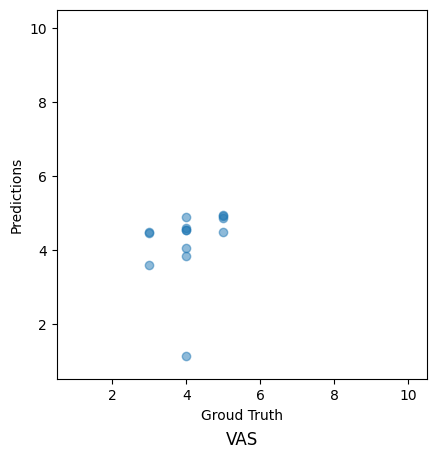

In [16]:
#plot the predicted and actual values
import matplotlib.pyplot as plt
# Convert torch tensors to numpy arrays for plotting
y_test_np = y_test.numpy()
test_outputs_np = test_outputs.numpy()

# Create a scatter plot
# make x and y axis have the same scale
plt.xlim(0.5, 10.5)
plt.ylim(0.5, 10.5)

plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(y_test_np, test_outputs_np, alpha=0.5)
plt.title('VAS', y=-0.2)
plt.xlabel('Groud Truth')
plt.ylabel('Predictions')
plt.show()

In [18]:
test_outputs

tensor([[4.9146],
        [1.1427],
        [4.4917],
        [3.5934],
        [4.9442],
        [4.5551],
        [4.4569],
        [4.4891],
        [4.6093],
        [3.8433],
        [4.8809],
        [4.5496],
        [4.8669],
        [4.0627]])

PhF


Epoch [1/10], Loss: 1.2931
Epoch [2/10], Loss: 0.6446
Epoch [3/10], Loss: 0.4301
Epoch [4/10], Loss: 0.4547
Epoch [5/10], Loss: 0.4901
Epoch [6/10], Loss: 0.4454
Epoch [7/10], Loss: 0.3803
Epoch [8/10], Loss: 0.3298
Epoch [9/10], Loss: 0.3071
Epoch [10/10], Loss: 0.3070
tensor([[1.4228],
        [0.3400],
        [0.9831],
        [1.0264],
        [0.8358],
        [1.4300],
        [1.3315],
        [1.0230],
        [0.9028],
        [1.3466],
        [1.4303],
        [1.3294],
        [0.9037],
        [0.9399]])
Test Loss: 0.3587


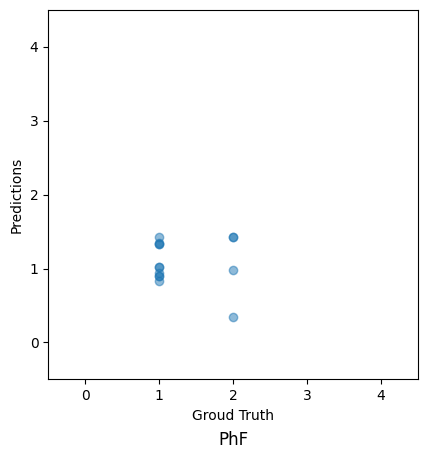

MF
Epoch [1/10], Loss: 6.5546
Epoch [2/10], Loss: 3.2220
Epoch [3/10], Loss: 1.6740
Epoch [4/10], Loss: 1.2886
Epoch [5/10], Loss: 1.3030
Epoch [6/10], Loss: 1.3601
Epoch [7/10], Loss: 1.3078
Epoch [8/10], Loss: 1.1502
Epoch [9/10], Loss: 0.9280
Epoch [10/10], Loss: 0.7104
tensor([[1.5639],
        [0.3937],
        [1.6656],
        [1.0804],
        [1.2186],
        [1.4428],
        [1.1679],
        [1.4114],
        [1.8724],
        [1.1323],
        [1.4513],
        [1.1674],
        [1.4479],
        [1.0084]])
Test Loss: 0.7757


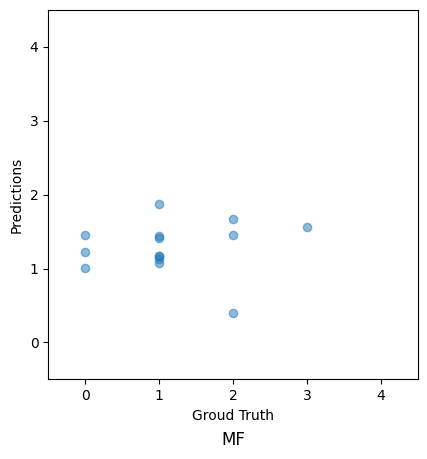

VAS
Epoch [1/10], Loss: 21.7716
Epoch [2/10], Loss: 16.0894
Epoch [3/10], Loss: 11.4357
Epoch [4/10], Loss: 8.2776
Epoch [5/10], Loss: 5.9325
Epoch [6/10], Loss: 3.9325
Epoch [7/10], Loss: 2.5303
Epoch [8/10], Loss: 1.8160
Epoch [9/10], Loss: 1.8069
Epoch [10/10], Loss: 2.1413
tensor([[5.9188],
        [1.3957],
        [5.4356],
        [4.6443],
        [5.7055],
        [6.1289],
        [5.8980],
        [4.9700],
        [5.4790],
        [5.4382],
        [5.3880],
        [5.8971],
        [5.8948],
        [5.0640]])
Test Loss: 2.8246


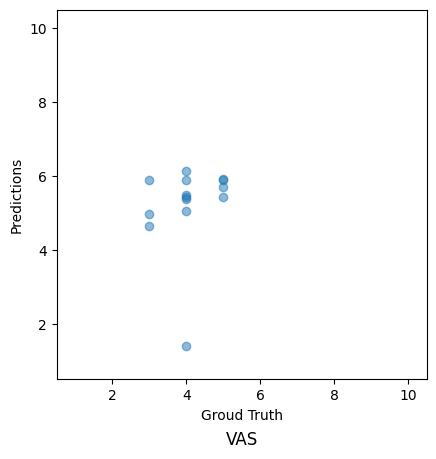

RelP
Epoch [1/10], Loss: 0.9495
Epoch [2/10], Loss: 0.7035
Epoch [3/10], Loss: 0.7015
Epoch [4/10], Loss: 0.6788
Epoch [5/10], Loss: 0.6266
Epoch [6/10], Loss: 0.5784
Epoch [7/10], Loss: 0.5754
Epoch [8/10], Loss: 0.5903
Epoch [9/10], Loss: 0.5840
Epoch [10/10], Loss: 0.5635
tensor([[ 0.0313],
        [ 0.3221],
        [ 0.0192],
        [ 0.1174],
        [-0.0303],
        [-0.0920],
        [-0.0797],
        [-0.0948],
        [ 0.1902],
        [ 0.1010],
        [ 0.0120],
        [-0.1533],
        [ 0.0726],
        [ 0.2522]])
Test Loss: 0.8683


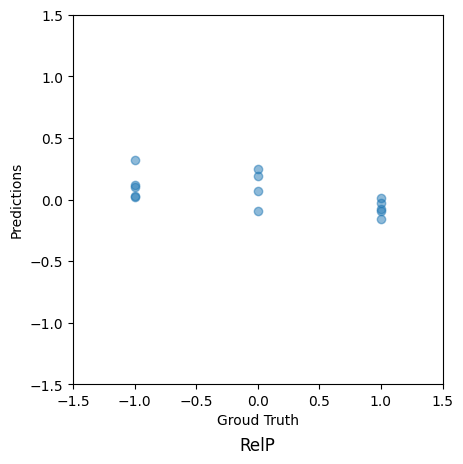

In [19]:
# repeat the above steps for PhF, MF, and RelP, do it in a loop
PROlabels = [PROlabels_PhF, PROlabels_MF, PROlabels_VAS, PROlabels_RelP]
PROlabels_name = ['PhF', 'MF', 'VAS', 'RelP']


for i in range(len(PROlabels)):
    np.random.seed(0)
    print(PROlabels_name[i])
    # Assuming your data is stored in 'data' and labels in 'labels'
    X_train, X_test, y_train, y_test = train_test_split(df24_5days, PROlabels[i], test_size=0.2, random_state=42)

    from torch.nn.utils.rnn import pad_sequence
    # Pad sequences with zeros
    X_train = pad_sequence([torch.tensor(seq, dtype=torch.float32) for seq in X_train], batch_first=True, padding_value=float('nan'))
    X_test = pad_sequence([torch.tensor(seq, dtype=torch.float32) for seq in X_test], batch_first=True, padding_value=float('nan'))
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    X_train = torch.nan_to_num(X_train)
    X_test = torch.nan_to_num(X_test)

    X_train.shape, y_train.shape, X_test.shape, y_test.shape
    # Instantiate the model
    input_size = 10  # Adjust according to your data
    hidden_size = 128
    output_size = 1  # Assuming regression task
    num_layers = 1
    consistency_attention_size = 128
    model = LSTMWithAttention(input_size, hidden_size, output_size, num_layers, consistency_attention_size)

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training the model
    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        print(test_outputs)
        test_loss = criterion(test_outputs.squeeze(), y_test)
        print(f'Test Loss: {test_loss.item():.4f}')
   
    # plot
    y_test_np = y_test.numpy()
    test_outputs_np = test_outputs.numpy()

    # Create a scatter plot
    # make x and y axis have the same scale
    if PROlabels_name[i] == 'VAS':
        plt.xlim(0.5, 10.5)
        plt.ylim(0.5, 10.5)
    elif PROlabels_name[i] == 'RelP':
        plt.xlim(-1.25, 1.25)
        plt.ylim(-1.25, 1.25)
    else:
        plt.xlim(-0.5, 4.5)
        plt.ylim(-0.5, 4.5)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(y_test_np, test_outputs_np, alpha=0.5)
    plt.title(PROlabels_name[i], y=-0.2)
    plt.xlabel('Groud Truth')
    plt.ylabel('Predictions')
    plt.show()


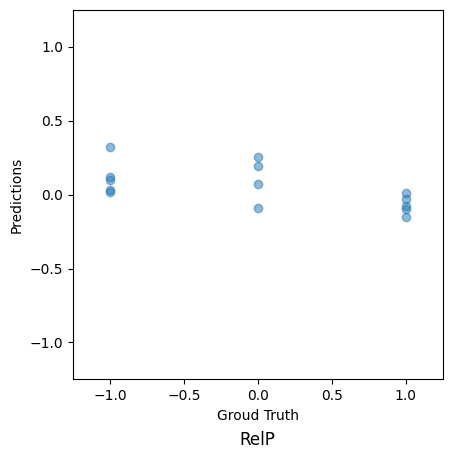

In [21]:
    # plot
y_test_np = y_test.numpy()
test_outputs_np = test_outputs.numpy()


plt.xlim(-1.25, 1.25)
plt.ylim(-1.25, 1.25)


plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(y_test_np, test_outputs_np, alpha=0.5)
plt.title(PROlabels_name[i], y=-0.2)
plt.xlabel('Groud Truth')
plt.ylabel('Predictions')
plt.show()